In [46]:
# Importing the libraries and functions
from functions import *

## 1. Overview

In [47]:
# Set the maximum width of the columns
pd.set_option('display.max_colwidth', 20)

In [49]:
# Load a dataframe with the disordered regions
disordered = pd.read_csv('disordered_df.csv')
disordered.head()

,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score,count
0,Q9H832,A0A6J2FM24,354,356,MAESPTEEAATA--GA...,MAESPTEEAATA GA...,MAESPTEEAATATAGA...,1,354,1,354,350,350,4,0.0,1851.0,200
1,Q9H832,A0A3Q7W6Y2,354,356,MAESPTEEAATA--GA...,MAESPTEEAATA GA...,MAESPTEEAATATAGA...,1,354,1,354,350,350,4,0.0,1851.0,200
2,Q9H832,A0A2U3VK69,354,356,MAESPTEEAATA--GA...,MAESPTEEAATA GA...,MAESPTEEAATATAGA...,1,354,1,354,350,350,4,0.0,1851.0,200
3,Q9H832,A0A2Y9JVH5,354,358,MAESPTEEAATA----...,MAESPTEEAATA ...,MAESPTEEAATATATA...,1,354,1,356,351,351,6,0.0,1854.0,200
4,Q9H832,A0A8C7ALE4,354,358,MAESPTEEAATA----...,MAESPTEEAATA ...,MAESPTEEAATATATA...,1,354,1,356,351,351,6,0.0,1854.0,200


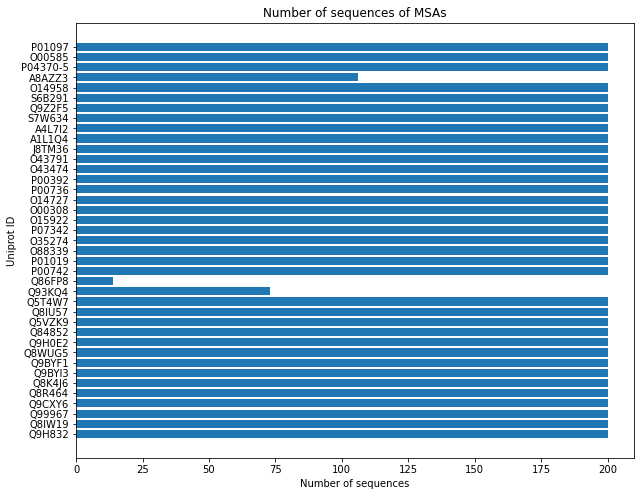

In [50]:
# Plot the number of sequences in each MSA
figure(figsize=(10, 8))
plt.barh(disordered['query_id'], disordered['count'])
plt.xlabel('Number of sequences')
plt.ylabel('Uniprot ID')
plt.title('Number of sequences of MSAs')
plt.show()

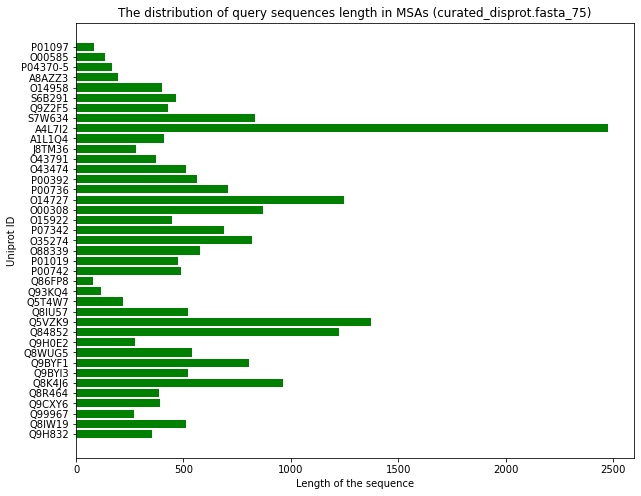

In [51]:
# Plot the length of sequences in the MSAs
figure(figsize=(10, 8))
plt.barh(disordered['query_id'], disordered['query_len'], color='green')
plt.xlabel('Length of the sequence')
plt.ylabel('Uniprot ID')
plt.title('The distribution of query sequences length in MSAs (curated_disprot.fasta_75)')
plt.show()

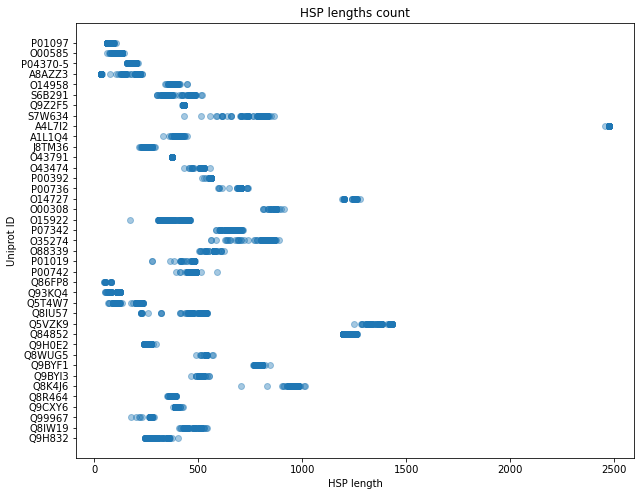

In [52]:
# Plot HSP length count
figure(figsize=(10, 8))
plt.scatter(disordered['hsp_len'], disordered['query_id'], alpha=0.4)
plt.xlabel('HSP length')
plt.ylabel('Uniprot ID')
plt.title('HSP lengths count')
plt.show()

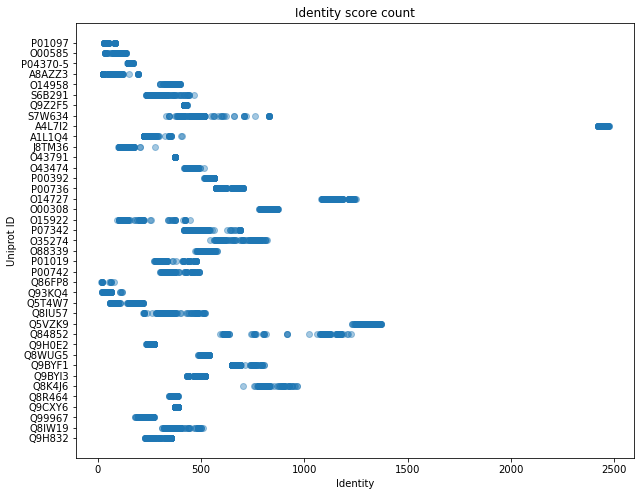

In [53]:
# Plot identity score count
figure(figsize=(10, 8))
plt.scatter(disordered['identity'], disordered['query_id'], alpha=0.4)
plt.xlabel('Identity')
plt.ylabel('Uniprot ID')
plt.title('Identity score count')
plt.show()

In [54]:
# Check if there are disordered regions for a particular query ID
%store -r id_dis id_split
selected_dis = disordered[disordered['query_id'].isin([id_split])]

# Filter the curated_disprot dataframe based on selected ID
curated_disprot = pd.read_csv('curated_disprot.csv')
curated_query = curated_disprot[curated_disprot['acc'] == id_split]
curated_query

,acc,evidence,feature,source,start,end,length,region
2996,P00392,curated,disorder,disprot,550,561,12,P00392_550-561


### 2. Query ID Analysis

Next, we determine the count of subject IDs for each query ID. It's important to note that we need to summarize the data for all subject IDs that occurred for a particular query, rather than for each individual 'query-sequence' pair.

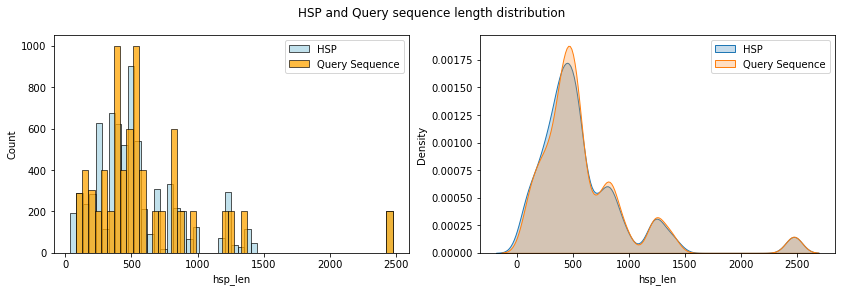

In [55]:
# Create bar plot for HSP hits - overall
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(disordered['hsp_len'], kde = False, bins = 50, color = 'lightblue', ax = ax1, label='HSP')
sns.histplot(disordered['query_len'], kde = False, bins = 50, color = 'orange', ax = ax1, label='Query Sequence')
sns.kdeplot(disordered['hsp_len'], shade = True, ax = ax2, label='HSP')
sns.kdeplot(disordered['query_len'], shade = True, ax = ax2, label='Query Sequence')
ax1.legend()
ax2.legend()
plt.suptitle(f'HSP and Query sequence length distribution')
plt.show()

The `histplot` shows the distribution of HSP lengths in the selected query ID by grouping the HSP lengths into bins or ranges along the x-axis and displaying the frequency of HSP lengths as the height of the corresponding bar on the y-axis.

The height of the `kdeplot` curve represents the estimated probability density of the variable being plotted at each point on the x-axis. For example, in the case of the HSP length, the height of the curve at a particular value of x represents the estimated density of observations around that value. The area under the curve represents the total probability of all possible values of the variable, which is equal to 1.

The `violinplot` provides the information about the interquartile range (thick gray line), median that is represented by a white dot and the rest of a distribution (thin gray line). The distribution's shape is presented on either side of the gray line through kernel density estimation. The wider sections of the violin plot represent a greater probability of the population taking on a specific value, while the narrower sections indicate a lower probability.

In [56]:
# # Create bar plot for HSP hits - for one ID
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
# sns.histplot(selected_dis['hsp_len'], kde = True, bins = 50, ax = ax1)
# sns.kdeplot(selected_dis['hsp_len'], shade = True, ax = ax2)
# sns.violinplot(x = selected_dis['hsp_len'], ax = ax3)
# plt.suptitle(f'HSP distribution for the {id_split} query ID')
# plt.show()

## 3. Multiple Sequence Alignment

Within this framework, we will compare the MSA results obtained directly from the BLAST output with those generated from the ClustalOmega service.

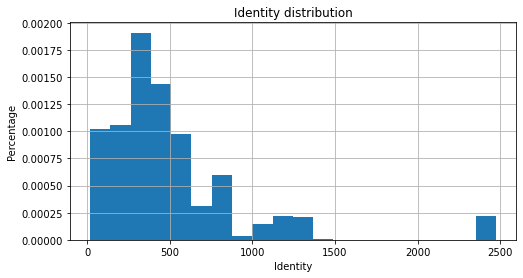

In [57]:
# Plot identity distribution
figure(figsize=(8, 4))
plt.hist(disordered['identity'], bins=20, density=True)  # Set density=True for percentage values
plt.xlabel('Identity')
plt.ylabel('Percentage')
plt.grid(True)
plt.title(f'Identity distribution')
plt.show()

In [59]:
# Import numpy arrays of MSAs from BLAST, ClustalOmega and MAFFT
%store -r blast_seqs 
# clustal_seqs mafft_seqs
# The number of sequences may differ
blast_seqs.shape, # clustal_seqs.shape, mafft_seqs.shape

((200, 561),)

### Removing redundant regions

For this step we use the input files for ClustalOmega or MAFFT alignment. The goal is to keep only non-redundant regions. We set the threshold for redundancy of 62%. The program implementing the task is called `cd-hit`.

Next, we will be working with the newly generated file. It will be uploaded to ebi website, where we will select Pearson/FASTA as the output format. Once we have downloaded the aligned sequences, we can analyze the alignment using Jalview.

In [60]:
# # Create a dataframe with the calculated redundancy
# redundancy_df = pd.read_csv('nr_75.csv', sep=';')
# redundancy_df.head()

In [61]:
# # Plot the redundancy distribution
# figure(figsize=(6, 4))
# plt.plot(redundancy_df['id'], redundancy_df['ratio'])
# plt.xlabel('Uniprot ID')
# plt.ylabel('Ratio')
# plt.xticks(rotation='vertical')
# plt.title('Distribution of redundancy of MSA')
# plt.show()

In [62]:
# # Plot the dendrogram
# %store -r data_file

# cluster_data = []
# with open(data_file, 'r') as file:
#     for line in file:
#         if line.startswith('>Cluster'):
#             continue
#         parts = line.strip().split('\t')
#         percentage_matches = re.findall(r'\d+\.\d+', parts[-1])
#         if percentage_matches:
#             percentage = float(percentage_matches[0])
#             cluster_data.append(percentage)

# # Convert the data into a matrix
# matrix_data = np.array(cluster_data).reshape(len(cluster_data), 1)

# # Create linkage matrix using the data and hierarchical clustering
# Z = linkage(matrix_data, method='average')

# # Plot the dendrogram
# plt.figure(figsize=(10, 6))
# dendrogram(Z, labels=np.arange(len(cluster_data)), leaf_rotation=90, leaf_font_size=8)

# # Add a horizontal line for the threshold
# threshold = 10.0
# plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold}%)')

# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel(f'Cluster Index for {id_split} protein')
# plt.ylabel('Distance')
# plt.show()

## 4. Analysing the quality of prediction

For calculation of the entropy we use a probability distribution with 20 outcomes, where each outcome has an equal probability of 1/20. Entropy is a measure of the uncertainty or randomness associated with a probability distribution. In this case, since the probability distribution is uniform, the entropy is maximized, meaning that there is maximum uncertainty or randomness associated with the outcomes.

With occupancy we define the proportion of non-missing (non-gap) values in the column.

### 4.1. Calculation of occupancy and entropy for initial MSA (redundant and non-redundant)

In [63]:
# Obtain the occupancy and entropy statistics for each type of MSA
%store -r nr_seqs id_split
nr_calc = stats_calculation(nr_seqs) # non-redundant MSA CLustalOmega
blast_calc = stats_calculation(blast_seqs) # initial MSA BLAST
# blast_calc.to_csv(f'results/stats/blast_calc_{id_split}.csv')
# clustal_calc = stats_calculation(clustal_seqs) # initial MSA ClustalOmega
# mafft_calc = stats_calculation(mafft_seqs) # initial MSA MAFFT

In [64]:
stats_total = pd.read_csv('results/stats_total.csv', index_col=0)
print(len(stats_total))
stats_total.head()

21870


,pos,query_id,occupancy,entropy,counts
0,0,P01019,1.0,0.000000,"[('M', 200)]"
1,1,P01019,1.0,0.346925,"[('A', 143), ('T..."
2,2,P01019,1.0,0.110752,"[('P', 186), ('A..."
3,3,P01019,1.0,0.191072,"[('A', 169), ('T..."
4,4,P01019,1.0,0.211104,"[('G', 166), ('S..."


In [66]:
stats_total['query_id'].nunique()

39

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


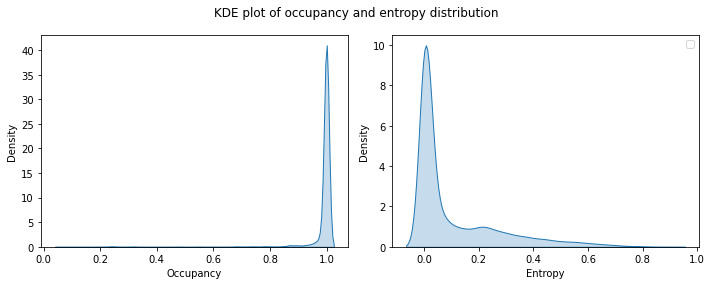

In [67]:
# KDE plot of occupancy/entropy
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.kdeplot(stats_total['occupancy'], shade = True, ax = ax[0])
sns.kdeplot(stats_total['entropy'], shade = True, ax = ax[1])

# Add x-axis labels to all subplots
x_axis_labels = ['Occupancy', 'Entropy']
for i in range(2):
    ax[i].set_xlabel(x_axis_labels[i])

plt.legend()

plt.suptitle(f'KDE plot of occupancy and entropy distribution')
plt.tight_layout()
plt.show()

/Users/alina/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


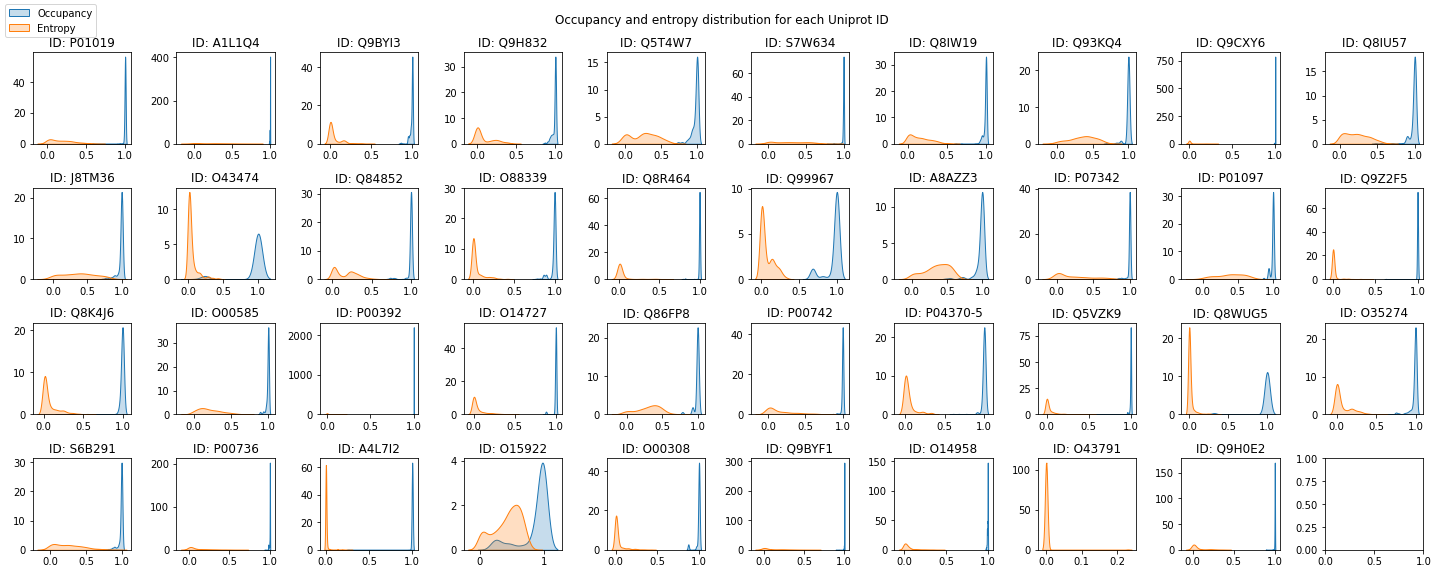

In [71]:
# Plot occupancy and entropy distribution
unique_query_ids = stats_total['query_id'].unique()
num_rows = 4

# Calculate the number of subplots in each row
# num_plots_in_row = len(unique_query_ids) // num_rows
num_plots_in_row = np.ceil(len(unique_query_ids) / num_rows).astype(int)


# Create subplots for each unique query_id
fig, axes = plt.subplots(num_rows, num_plots_in_row, figsize=(20, 8))

for i, query_id in enumerate(unique_query_ids):
    subset = stats_total[stats_total['query_id'] == query_id]
    row_index = i // num_plots_in_row  # Determine the row for the current instance
    col_index = i % num_plots_in_row   # Determine the column for the current instance
    
    sns.kdeplot(subset['occupancy'], shade=True, ax=axes[row_index, col_index], label='Occupancy')
    sns.kdeplot(subset['entropy'], shade=True, ax=axes[row_index, col_index], label='Entropy')
    
    axes[row_index, col_index].set_ylabel('')
    axes[row_index, col_index].set_xlabel('')

    axes[row_index, col_index].set_title(f'ID: {query_id}')
    
fig.legend(loc='upper left', labels=['Occupancy', 'Entropy'])
    
plt.suptitle('Occupancy and entropy distribution for each Uniprot ID')
plt.tight_layout()
plt.show()

In [34]:
length_blast = len(blast_seqs)
length_clustal = len(clustal_seqs)
length_mafft = len(mafft_seqs)
length_nr = len(nr_seqs)
print(id_split, length_nr, )
nr_seqs

Q8IW19 4


array([['M', 'S', 'G', ..., 'K', 'R', 'K'],
       ['N', 'K', 'G', ..., 'K', 'R', 'K'],
       ['M', 'S', 'G', ..., 'K', 'R', 'K'],
       ['M', 'S', 'G', ..., 'K', 'R', 'K']], dtype='<U1')

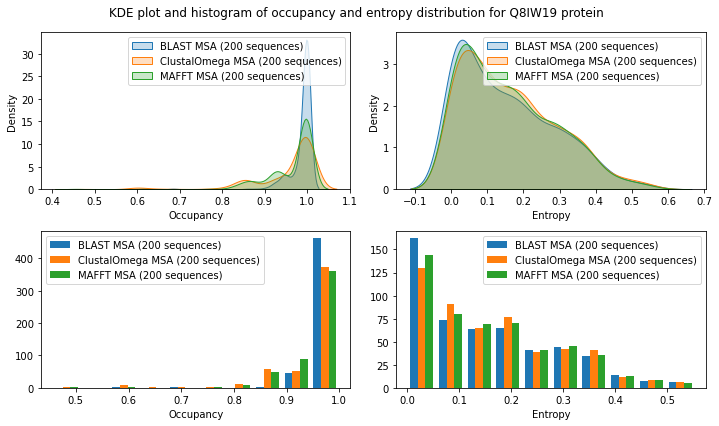

In [35]:
# KDE plot of occupancy/entropy BLAST/ClustalOmega/MAFFT
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

sns.kdeplot(blast_calc['occupancy'], shade = True, ax = ax[0,0])
sns.kdeplot(clustal_calc['occupancy'], shade = True, ax = ax[0,0])
sns.kdeplot(mafft_calc['occupancy'], shade = True, ax = ax[0,0])

sns.kdeplot(blast_calc['entropy'], shade = True, ax = ax[0,1])
sns.kdeplot(clustal_calc['entropy'], shade = True, ax = ax[0,1])
sns.kdeplot(mafft_calc['entropy'], shade = True, ax = ax[0,1])

# Histogram of occupancy/entropy redundant vs non-redundant
ax[1,0].hist([blast_calc['occupancy'], clustal_calc['occupancy'], mafft_calc['occupancy']])
ax[1,1].hist([blast_calc['entropy'], clustal_calc['entropy'], mafft_calc['entropy']])

# Add x-axis labels to all subplots
x_axis_labels = ['Occupancy', 'Entropy']
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel(x_axis_labels[j])

# Add the common legend (assuming you have already done this)
legend_labels = [f'BLAST MSA ({length_blast} sequences)', 
                 f'ClustalOmega MSA ({length_clustal} sequences)', 
                 f'MAFFT MSA ({length_mafft} sequences)']

for ax in ax.flat:
    ax.legend(legend_labels)

plt.suptitle(f'KDE plot and histogram of occupancy and entropy distribution for {id_split} protein')
plt.tight_layout()
plt.show()

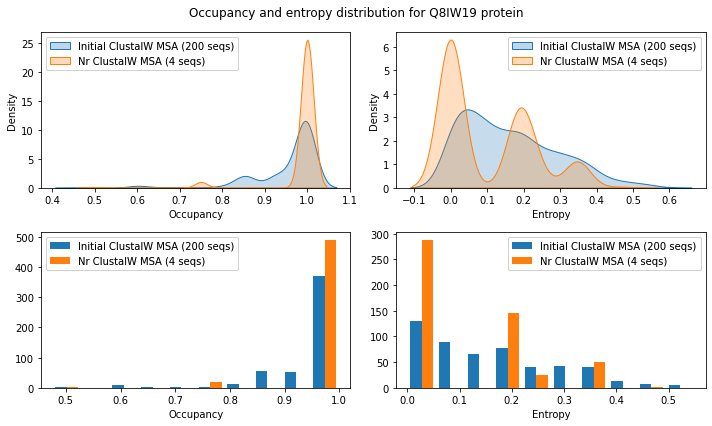

In [37]:
# KDE plot of occupancy/entropy redundant vs non-redundant - ClustalOmega
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

sns.kdeplot(clustal_calc['occupancy'], shade = True, ax = ax[0,0])
sns.kdeplot(nr_calc['occupancy'], shade = True, ax = ax[0,0])

sns.kdeplot(clustal_calc['entropy'], shade = True, ax = ax[0,1])
sns.kdeplot(nr_calc['entropy'], shade = True, ax = ax[0,1])

# Histogram of occupancy/entropy redundant vs non-redundant
ax[1,0].hist([clustal_calc['occupancy'], nr_calc['occupancy']])
ax[1,1].hist([clustal_calc['entropy'], nr_calc['entropy']])

# Add x-axis labels to all subplots
x_axis_labels = ['Occupancy', 'Entropy']
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel(x_axis_labels[j])

# Add the common legend (assuming you have already done this)
legend_labels = [f'Initial ClustalW MSA ({length_clustal} seqs)', 
                 f'Nr ClustalW MSA ({length_nr} seqs)']
    
for i in range(2):
    for j in range(2):
        legend = ax[i, j].legend(legend_labels, loc='upper left' if j == 0 else 'upper right')
        ax[i, j].add_artist(legend)

plt.suptitle(f'Occupancy and entropy distribution for {id_split} protein')
plt.tight_layout()
plt.show()

### 4.2. Calculation of occupancy and entropy for disordered regions of MSA

#### 4.2.1 Occupancy and entropy for several disordered regions in initial MSA

In [38]:
# Calculate occupancy and entropy for the 1st disordered region
%store -r dis_calc0 dis_calc1
%store -r dis_calc_nr0 dis_calc_nr1
# dis_calc0.head()

In [39]:
# # Calculate occupancy and entropy for the 2nd disordered region
# dis_calc1.head()

In [40]:
# Plot occupancy/entropy for disordered regions
def plot_disordered_regions(id_split, l_cl, l_nr, dis_calc_num):
    # Define the data frame names
    dis_calc_name = f"dis_calc{dis_calc_num}"
    dis_calc_nr_name = f"dis_calc_nr{dis_calc_num}"

    # Define the figure and axes
    fig, ax = plt.subplots(2, 2, figsize=(10, 6))

    # KDE plot of occupancy/entropy of disordered region
    sns.kdeplot(eval(dis_calc_name)['occupancy'], shade=True, ax=ax[0, 0], warn_singular=False)
    sns.kdeplot(eval(dis_calc_nr_name)['occupancy'], shade=True, ax=ax[0, 0], warn_singular=False)
    sns.kdeplot(eval(dis_calc_name)['entropy'], shade=True, ax=ax[0, 1], warn_singular=False)
    sns.kdeplot(eval(dis_calc_nr_name)['entropy'], shade=True, ax=ax[0, 1], warn_singular=False)

    # Histogram of occupancy/entropy redundant vs non-redundant
    ax[1, 0].hist([eval(dis_calc_name)['occupancy'], eval(dis_calc_nr_name)['occupancy']])
    ax[1, 1].hist([eval(dis_calc_name)['entropy'], eval(dis_calc_nr_name)['entropy']])

    # Add x-axis labels
    x_axis_labels = ['Occupancy', 'Entropy']
    for i in range(2):
        for j in range(2):
            ax[i, j].set_xlabel(x_axis_labels[j])

    # Add the legend
    legend_labels = [f'Initial MSA ({l_cl} sequences)', f'Non-redundant MSA ({l_nr} sequences)']
    for ax in ax.flat:
        ax.legend(legend_labels)

    plt.suptitle(f'KDE plot and histogram of occupancy and entropy distribution for {id_split}_{dis_calc_num+1} protein')
    plt.tight_layout()
    plt.show()


In [41]:
# Plot the statistics for the 1st disordered region
plot_disordered_regions(id_split, length_cl, length_nr, 0)

NameError: name 'length_cl' is not defined

In [42]:
# Plot the statistics for the 2nd disordered region
plot_disordered_regions(id_split, length_cl, length_nr, 1)

NameError: name 'length_cl' is not defined

#### 4.2.2 Occupancy and entropy for one disordered region in initial MSA

In [43]:
# # Calculate occupancy and entropy for the region
%store -r dis_calc
%store -r dis_calc_nr
# dis_calc

NameError: name 'length' is not defined

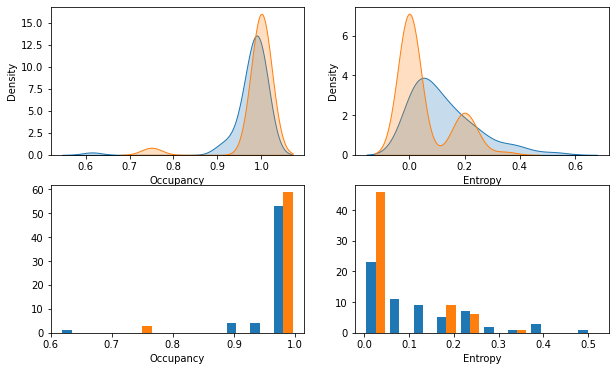

In [44]:
# KDE plot of occupancy/entropy of 1 disordered region
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

sns.kdeplot(dis_calc['occupancy'], shade = True, ax = ax[0,0])
sns.kdeplot(dis_calc_nr['occupancy'], shade = True, ax = ax[0,0])
sns.kdeplot(dis_calc['entropy'], shade = True, ax = ax[0,1])
sns.kdeplot(dis_calc_nr['entropy'], shade = True, ax = ax[0,1])

# Histogram of occupancy/entropy redundant vs non-redundant
ax[1,0].hist([dis_calc['occupancy'], dis_calc_nr['occupancy']])
ax[1,1].hist([dis_calc['entropy'], dis_calc_nr['entropy']])

# Add x-axis labels
x_axis_labels = ['Occupancy', 'Entropy']
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel(x_axis_labels[j])

# Add the legend
legend_labels = ['Initial MSA', f'Non-redundant MSA ({length} sequences)']
for ax in ax.flat:
    ax.legend(legend_labels)

plt.suptitle(f'KDE plot and histogram of occupancy and entropy distribution for {id_split} protein')
plt.tight_layout()
plt.show()